In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
import sys, os, pickle, string

from autophasemap import plot_clusters
color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd", "#94a4a2"]
bkg_spectra_color = "#717581"

SAVE_DIR = "../../figures/P123_Temp/"

In [15]:
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight'
              } 

In [16]:
with open('./data_smooth4.pkl', 'rb') as f:
    result = pickle.load(f)
    
saxs = np.load('../../expts/OMIECS/PPBT_0_P123_Y_Temp.npz')
n_clusters = 4

q = saxs['q']
n_domain = len(saxs['q'])

temp_flags = saxs['c'][:,1]<85
C = saxs['c'][temp_flags,:]
Iq = saxs['Iq'][temp_flags,:]

N = C.shape[0]

In [17]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, process=None):
        if process=="normalize":
            self.F = [self.Iq[i]/self.l2norm(self.Iq[i]) for i in range(self.N)]
        elif process=="smoothen":
            self.F = [self._smoothen(self.Iq[i,:]/self.l2norm(self.Iq[i])) for i in range(self.N)]
        elif process is None:
            self.F = [self.Iq[i] for i in range(self.N)]
            
        return
        
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 8, 3)
        
        return f_hat
    
data = DataSet(C, q, Iq, N, n_domain=n_domain)
data.generate(process="smoothen")
print('Total number of samples %d'%data.N)

Total number of samples 425


In [18]:
def setup_axs():
    fig, axs = plt.subplots(2,2, figsize=(4*2, 4*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    axs = axs.flatten()
    for k in range(4):
        axs[k].text(0.1, 0.9, r'(%s)'%string.ascii_uppercase[k], 
        transform=axs[k].transAxes, 
        size=20, weight='bold'
        )
    return fig, axs

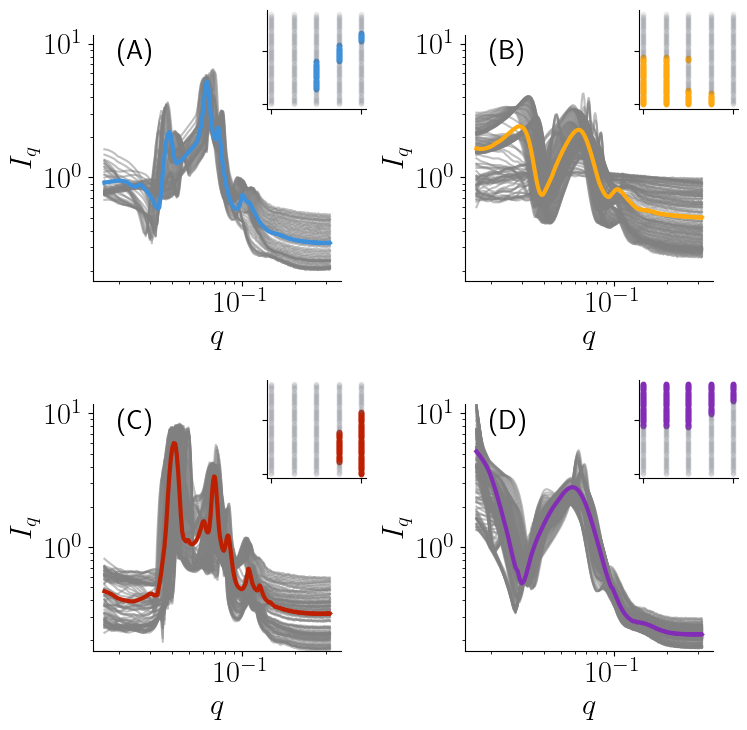

In [19]:
with plt.style.context(pyplot_style):
    fig, axs = setup_axs()
    plot_clusters(axs, data, result, mode="input")
    plt.savefig(SAVE_DIR+'templates_4.pdf')

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_2353/3918624311.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


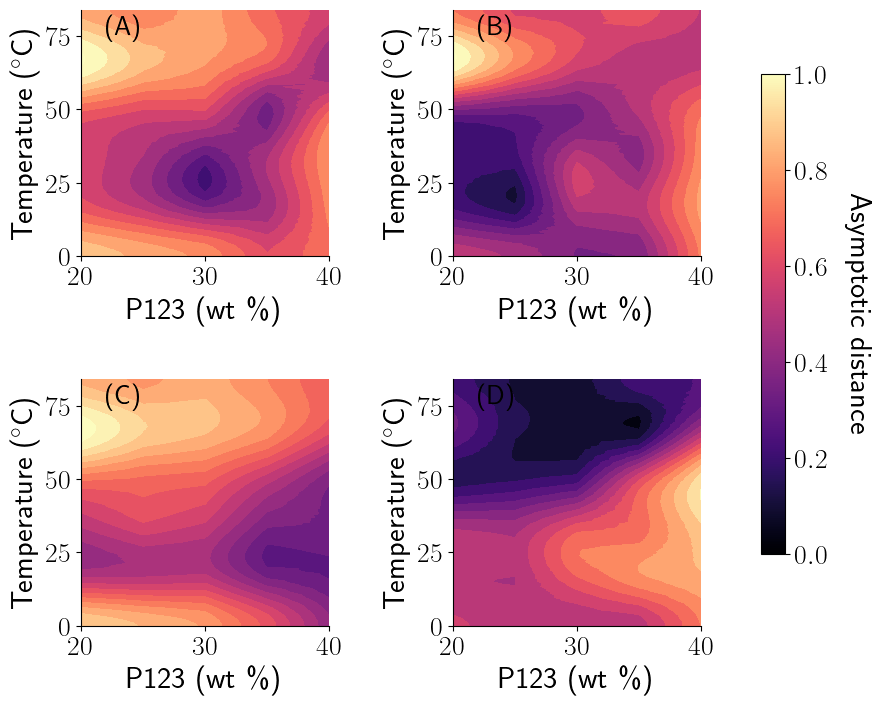

In [20]:
cmap = cm.get_cmap('magma')
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

def plot_contours_distance(axs, data, result):
    for k, ax in enumerate(axs):
        ax.tricontourf(data.C[:,0], 
                       data.C[:,1], 
                       result['dist'][:,k], 
                       15,
                       cmap=cmap,
                       norm = norm
                      )

        ax.set_xlabel('P123 (wt \%)', fontsize=22)
        ax.set_ylabel('Temperature ($^{\circ}$C)', fontsize=22)
        ax.tick_params(labelsize=20)

    return 

with plt.style.context(pyplot_style):
    fig, axs = setup_axs()
    plot_contours_distance(axs, data, result) 
    cax = plt.axes([0.975, 0.2, 0.03, 0.6])        
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel('Asymptotic distance', 
                       rotation=270, 
                       labelpad=32, 
                       fontsize=22
                       )
    plt.savefig(SAVE_DIR+'distances_4.pdf')
    plt.show()

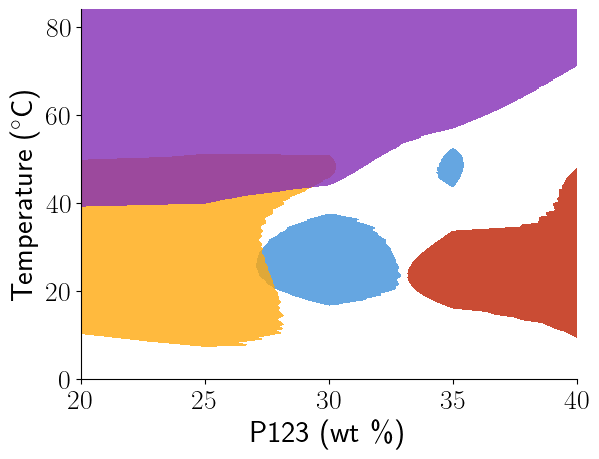

In [21]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    for k in range(n_clusters):
        ax.tricontourf(data.C[:,0], 
                       data.C[:,1], 
                       result['dist'][:,k], 
                       levels=[0.0, 0.35],
                       colors=color_blindf[k],
                       alpha=0.8
                      )

    ax.set_xlabel('P123 (wt \%)', fontsize=22)
    ax.set_ylabel('Temperature ($^{\circ}$C)', fontsize=22)
    ax.tick_params(labelsize=20)
    plt.savefig(SAVE_DIR+'phasemap_th35_4.pdf')
    plt.show()

In [22]:
def setup_axs():
    layout = [['A1','A2', 'A3', 'A4', 'C', 'C'], 
              ['B1', 'B2', 'B3', 'B4', 'C', 'C']
              ]
    fig, axs = plt.subplot_mosaic(layout, figsize=(4*6, 4*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    for k, (_,ax) in enumerate(axs.items()):
        ax.text(0.1, 0.9, r'(%s)'%string.ascii_uppercase[k], 
        transform=ax.transAxes, 
        size=20, weight='bold'
        )
    return fig, axs

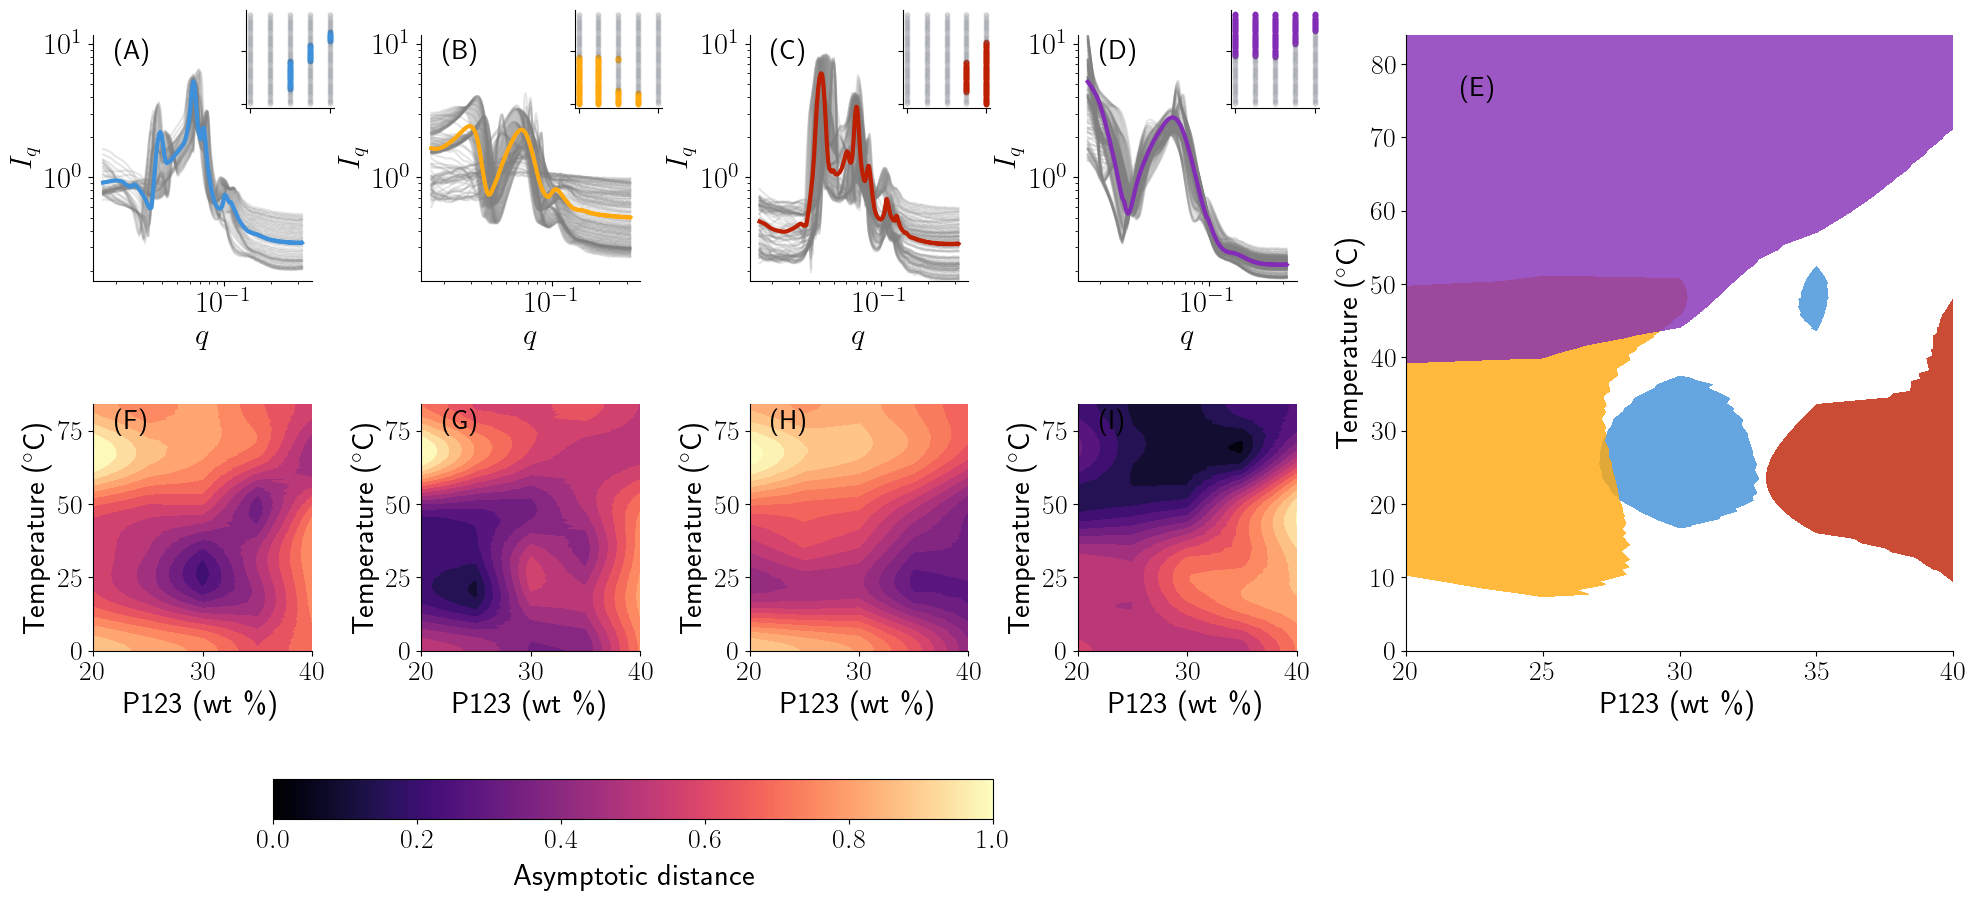

In [24]:
with plt.style.context(pyplot_style):
    fig, axs = setup_axs()
    ax_clusters = [axs[k] for k in ['A1', 'A2', 'A3', 'A4']]
    plot_clusters(ax_clusters,data, result, mode="input")

    ax_contours = [axs[k] for k in ['B1', 'B2', 'B3', 'B4']]
    plot_contours_distance(ax_contours,data, result)

    norm = Normalize(vmin=0, vmax=1)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([0.2, -0.1, 0.3, 0.05])        
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_xlabel('Asymptotic distance',
                    labelpad=8,
                    fontsize=22,
                    rotation='horizontal'
                    )

    ax_map = axs['C']
    for k in range(n_clusters):
        ax_map.tricontourf(data.C[:,0], 
                    data.C[:,1],
                    result['dist'][:,k],
                    levels=[0.0, 0.35],
                    colors=color_blindf[k],
                    alpha=0.8
                    )

    ax_map.set_xlabel('P123 (wt \%)', fontsize=22)
    ax_map.set_ylabel('Temperature ($^{\circ}$C)', fontsize=22)
    ax_map.tick_params(labelsize=20)
    plt.savefig(SAVE_DIR+'full_template4.pdf')
    plt.show()